In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv("../.env")
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
# DATASET_PATH=os.path.join("/home/david/Downloads")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")
# from mmwave_model_integrator.torch_training.models.SequentialDynamicEdgeConv import SequentialDynamicEdgeConv
from mmwave_model_integrator.torch_training.models.TwoStreamSpatioTemporalGnn import TwoStreamSpatioTemporalGnn
from mmwave_model_integrator.torch_training.models.HierarchicalAnchorNet import HierarchicalAnchorNet
from mmwave_model_integrator.torch_training.models.Ruiyang_test_model import RuiyangTestModel
from cpsl_datasets.gnn_node_ds import GnnNodeDS

from mmwave_model_integrator.input_encoders._node_encoder import _NodeEncoder
from mmwave_model_integrator.ground_truth_encoders._gt_node_encoder import _GTNodeEncoder
from mmwave_model_integrator.plotting.plotter_gnn_pc_processing import PlotterGnnPCProcessing
from mmwave_model_integrator.model_runner.gnn_runner import GNNRunner
# from mmwave_model_integrator.torch_training.models.SequentialDynamicEdgeConv import SequentialDynamicEdgeConv
from mmwave_model_integrator.torch_training.models.SAGEGnn import SageGNNClassifier
from mmwave_model_integrator.plotting.movie_generator_gnn import MovieGeneratorGNN


/home/david/.cache/pypoetry/virtualenvs/odometry-JJ4jnFPp-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#initialize the dataset
config_label = "IcaRAus_gnn_two_stream"
dataset_label = "IcaRAus_gnn_50fh"
dataset_path = os.path.join(DATASET_PATH,"IcaRAus_datasets","{}_train".format(dataset_label))
dataset = GnnNodeDS(
    dataset_path=dataset_path,
    node_folder="nodes",
    label_folder="labels"
)
print(dataset_path)

found 5261 node samples
found 5261 label samples
/home/david/Downloads/IcaRAus_datasets/IcaRAus_gnn_50fh_train


In [4]:
#initialize the encoder and decoder
input_encoder = _NodeEncoder()
ground_truth_encoder = _GTNodeEncoder()
plotter = PlotterGnnPCProcessing()

# testing the output
model = TwoStreamSpatioTemporalGnn(
    hidden_channels=28,
    out_channels=1,
    k=4, #original is 40
    dropout=0.1
)

# model = HierarchicalAnchorNet(
#     in_channels=4,
#     hidden_channels=64,
#     out_channels=1,
#     num_anchors=300,
#     use_attention_aggregator=False
# )

model = RuiyangTestModel(
    hidden_channels=28,
    out_channels=1,
    k=4,
    dropout=0.1,
    in_channels=None,
    use_gnn=True,
    use_global_context=True,
    encoded_global_dim=3
)

runner = GNNRunner(
    model= model,
    state_dict_path="/home/david/Documents/odometry/submodules/mmwave_model_integrator/scripts/working_dir/IcaRAus_gnn_IcaRAus_ds/IcaRAus_Ruiyang_test_model_IcaRAus_ds_global_gnn.pth",
    cuda_device="cpu",
    edge_radius=10.0, #unused for this model
    enable_downsampling=False,
    downsample_keep_ratio=0.40,
    downsample_min_points=300,
    use_sigmoid=True
)

movie_generator = MovieGeneratorGNN(
    gnn_ds=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=None,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.path.join(os.getenv("MOVIE_TEMP_DIRECTORY"),config_label)
)

_ModelRunner: using CPU
Total number of parameters: 31898
found temp dir: /home/david/Downloads/radnav_temp_dir/IcaRAus_gnn_two_stream
clearing temp directory /home/david/Downloads/radnav_temp_dir/IcaRAus_gnn_two_stream


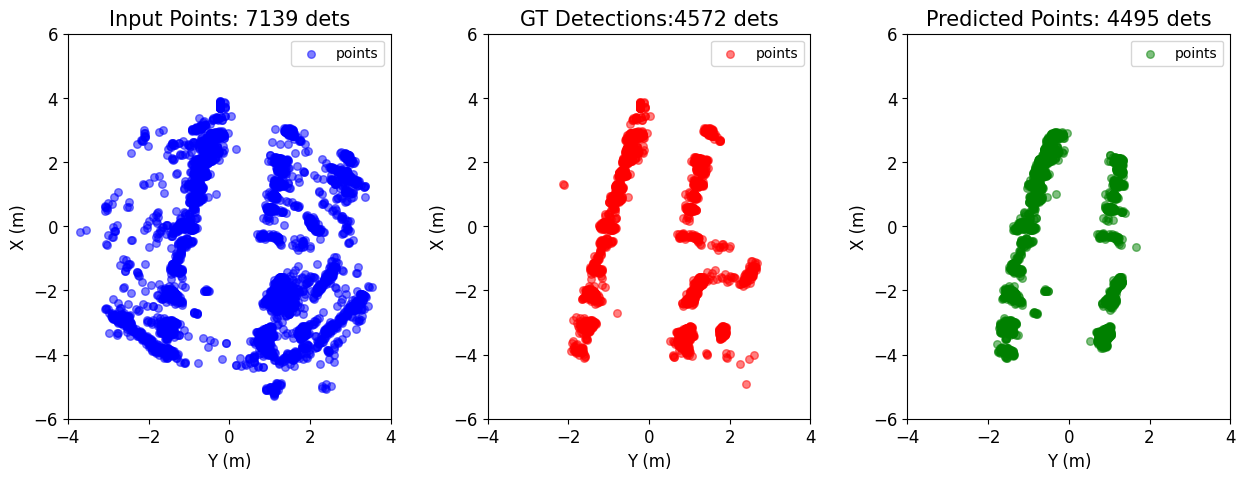

In [5]:
#plot a sample from the training dataset
idx = 980 #980 good for imaging #3000 good on 10fp_20fh_0_50_th_5mRng_0_2_res_train
nodes = dataset.get_node_data(idx)
labels = dataset.get_label_data(idx)
plotter.plot_compilation(
    input_data=nodes,
    gt_data=labels,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    runner=runner,
    show=True
)

In [7]:
idx = 980
nodes = dataset.get_node_data(idx)
labels = dataset.get_label_data(idx)

print(nodes)
print(labels)

pred = runner.make_prediction(nodes)
print(pred)

[[ 1.51660005  0.89944708  0.11        0.02      ]
 [-0.35878599 -0.74132217  0.11        0.02      ]
 [-0.33761109 -0.75136924  0.11        0.02      ]
 ...
 [-3.45325899 -0.96899945  0.11        1.        ]
 [-3.50888872 -0.75366622  0.11        1.        ]
 [-3.53175879 -0.75879323  0.11        1.        ]]
[False  True  True ...  True  True  True]
[[-2.4058826 -1.4731483  0.11       0.3      ]
 [-2.1517081 -1.2746121  0.11       0.54     ]
 [ 2.088872  -1.2947817  0.11       0.5      ]
 ...
 [ 1.2942601  0.8097093  0.11       0.8      ]
 [-1.9407474 -1.0974534  0.11       0.98     ]
 [ 2.0043604  0.5699166  0.11       0.96     ]]


In [6]:
#quick speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    nodes = dataset.get_node_data(idx=i)
    labels = dataset.get_label_data(idx=i)

    pred = runner.make_prediction(nodes)

  5%|▌         | 284/5261 [00:05<01:43, 48.06it/s]


KeyboardInterrupt: 

  0%|          | 0/5260 [00:00<?, ?it/s]

100%|██████████| 5260/5260 [03:33<00:00, 24.59it/s]


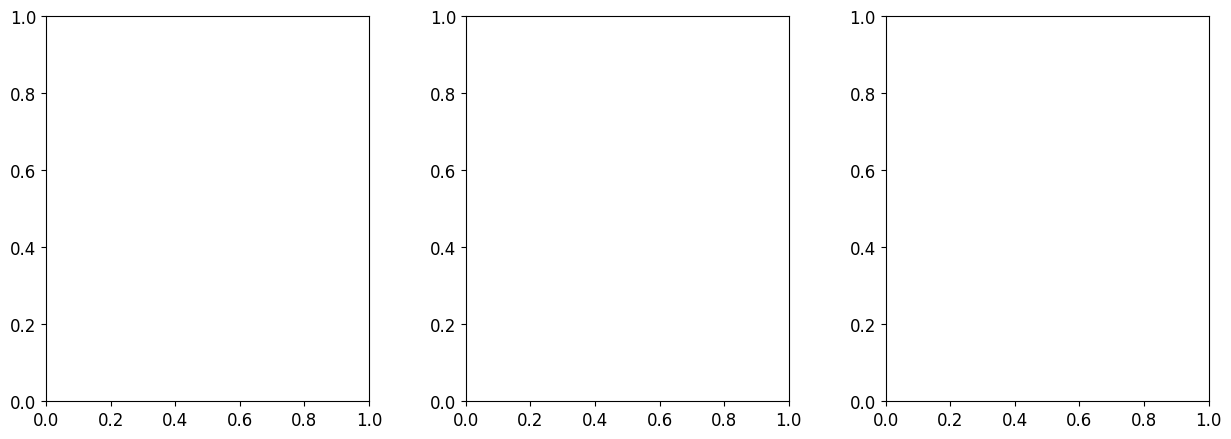

In [8]:
movie_generator.initialize_figure(
    nrows=1,
    ncols=3,
    figsize=(15,5),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

movie_generator.save_movie(video_file_name="{}.mp4".format("{}_mov".format(config_label)),fps=20)